# Create TRY summary statistics per species

In this section we download and preprocess the TRY trait data. The TRY database contains trait measurements from individual plants and, typically, multiple individual measurements per trait and species. We want an mean (and stadard deviation) for each trait value per species.

This section covers:

- Download TRY Data
- Load data
- Fuzzy Aggregation of species names
- Mean trait measurement per species

## Packages

In [ ]:
import pandas as pd # dataframes
import numpy as np  
import os # system interface
import matplotlib.pyplot as plt # plotting

# fuzzy matching
#import rapidfuzz
from rapidfuzz import process, fuzz

## Download TRY Data

To download data from the TRY database, create an account at https://www.try-db.org/de.

We choose the option of open access data only, but the curators of this database still require you to add a short project description to your download request. You will then be sent a download link via e-mail.

For this study we will use continuous (con) traits used in the sPlot analysis from Buehlheide et al. 2018:


| Trait     | ID     | Unit    |
| :------------- | :----------: | -----------: |
| Leaf area (in case of compound leaves: leaflet, undefined if petiole is in- or excluded) | 3113 | mm^2 |
| Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): undefined if petiole is in- or excluded) | 3117 |m^2/kg|
| Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume) | 4 | g/cm^3 |
| Leaf carbon (C) content per leaf dry mass | 13 | mg/g |
| Leaf nitrogen (N) content per leaf dry mass| 14 | mg/g |
| Leaf phosphorus (P) content per leaf dry mass| 15| mg/g |
| Plant height vegetative | 3106 | m |
| Seed dry mass | 26 | mg |
| Seed length | 27 | mm |
| Leaf dry mass per leaf fresh mass (leaf dry matter content, LDMC) | 47 | g/g |
| Leaf nitrogen (N) content per leaf area | 50   | g/m^2 |
| Leaf nitrogen/phosphorus (N/P) ratio | 56 | g/g |
| Leaf nitrogen (N) isotope signature (delta 15N) | 78 | ppm |
| Seed number per reproducton unit | 138 |  |
| Leaf fresh mass | 163 | g
| Stem conduit density (vessels and tracheids) | 169 | mm-2 |
| Dispersal unit length | 237 | mm |
| Wood vessel element length; stem conduit (vessel and tracheids) element length | 282 | μm |




When asked which traits you would like to download, type in the following list. This filters TRY data for our traits of interest, listed in the table above.

```3113, 3117, 4, 13, 14, 15, 3106, 26, 27, 47, 50, 56, 78, 138, 163, 169, 237, 282```

## Load TRY data

First, load the TRY data as a data frame, selecting only the following columns:
- **AccSpeciesName** - Consolidated species name
- **SpeciesName** - Species name
- **TraitID** - Unique identifier for traits (only if the record is a trait)
- **TraitName** - Name of trait (only if the record is a trait)
- **StdValue** - Standardized value: available for standardized traits

In [ ]:
TRYdata = pd.read_csv("TRY/19287.txt", sep = "\t", encoding="iso-8859-1", 
                      usecols = ["AccSpeciesName", "SpeciesName", "TraitID", "TraitName", "StdValue"],
                     dtype={'TraitID': float})



In [ ]:
TRYdata.head()

Each row represents one trait measurements performed on one individual plant. To get an idea of the data, look at the shape of the dataframe. We then remove the observations that do not have measurements for out traits of interest, i.e. the ```trait ID``` is ```NaN```.

In [4]:
TRYdata.shape

(16015161, 5)

In [5]:
TRYdata = TRYdata.dropna(subset=["TraitID"])

In [6]:
# check number of unique trait names
TRYdata["TraitID"].nunique()

18

In [7]:
# number of unique species
TRYdata["AccSpeciesName"].nunique()

54739

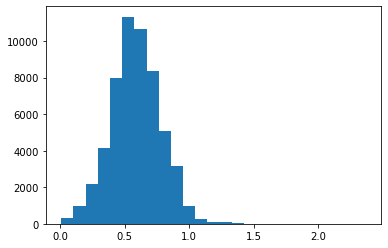

In [8]:
# Test histrogramm output for Stem specific density (SSD) as an example:

StdValues = TRYdata.loc[TRYdata["TraitID"] == 4, ["StdValue"]]
plt.hist(StdValues, bins=25);

## Fuzzy Aggregation of species names

Are there duplicates in the TRY species names?

We remove author annotation from species names, since the data we want to later merge TRY data with - iNaturalist, observations - only have species names without author annotations. 

In [9]:
# make all letters lower case
TRYdata['AccSpeciesName'] = TRYdata['AccSpeciesName'].str.lower()
# capitalize first letter in string
TRYdata['AccSpeciesName'] = TRYdata['AccSpeciesName'].str.capitalize()
# get only two first words (split at space)
TRYdata['AccSpeciesName']  = TRYdata['AccSpeciesName'].apply(lambda x: ' '.join(x.split()[0:2]))
# change type to string
TRYdata['AccSpeciesName'] = TRYdata['AccSpeciesName'].astype(str)

# same for species name
TRYdata['SpeciesName'] = TRYdata['SpeciesName'].str.lower()
TRYdata['SpeciesName'] = TRYdata['SpeciesName'].str.capitalize()
TRYdata['SpeciesName'] = TRYdata['SpeciesName'].astype(str)
TRYdata['SpeciesName']  = TRYdata['SpeciesName'].apply(lambda x: ' '.join(x.split()[0:2]))

Unique species:

In [10]:
TRY_sp = TRYdata["AccSpeciesName"].apply(str)
TRY_sp = TRY_sp.unique()

In [11]:
len(TRY_sp)

51908

In [12]:
def fuzzy_match(choices, queries, cutoff):
    
    score_sort = [(x,) + i
             for x in queries
             for i in process.extract(x, choices, score_cutoff=cutoff, scorer=fuzz.token_sort_ratio) ]
    
    similarity_sort = pd.DataFrame(score_sort)
    similarity_sort = similarity_sort[similarity_sort[2] != 100.0]
    return similarity_sort

In [13]:
TRY_matches = fuzzy_match(TRY_sp, TRY_sp, 95)

In [14]:
TRY_matches.head()

,0,1,2,3
86,Rosmarinus officinalis,Rosmarinus officilis,95.238095,49470
97,Symphoricarpos albus,Symphoricarpus albus,95.000000,45580
135,Chionochloa rigida,Chionochloa frigida,97.297297,10863
172,Andropogon gerardii,Andropogon gerardi,97.297297,9294
354,Tourouli guianensis,Touroulia guianensis,97.435897,25350


In [15]:
TRY_matches[0].nunique()

516

Only 0.5% of unique species in TRY have potential duplicates (similar names). We decided to diregard this slight uncertainty and accepted that these species might not be matched to the iNaturalist observations.

We devide the number for matches by 2, since every pair is listed twice (positions switched).

In [16]:
(len(TRY_matches)/2)/len(TRY_sp)

0.005124450951683748

## Mean trait measurement per species

Here we create a dataframe with one species per row with a mean trait value and standard deviations for each trait in the following columns.

Number of unique species:

In [17]:
TRYdata['AccSpeciesName'].nunique()

51908

In [18]:
TRYdata['SpeciesName'].nunique()

61181

### Create summary stats with consolidated species name

Use ```groupby``` function to group data by consolidated species name and trait; grouping variables: ```AccSpeciesName, TraitName, TraitID```.

More information: https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm

In [19]:
# group data by species name and trait

grouped = TRYdata.groupby(['AccSpeciesName', 'TraitID', 'TraitName'])



Calculate statistics (mean and standard deviation) using the aggregate function on each group. This returns a data frame with the mean and standard deviation for each species and each trait per row. Reset indeces (species name, trait ID and trait name) as columns in dataframe.

In [20]:
TRYsummary = grouped['StdValue'].agg([np.mean]).reset_index()

#check output
TRYsummary.head()

,AccSpeciesName,TraitID,TraitName,mean
0,Aa,14.0,Leaf nitrogen (N) content per leaf dry mass,26.400000
1,Aa,50.0,Leaf nitrogen (N) content per leaf area,2.798400
2,Aa,3117.0,Leaf area per leaf dry mass (specific leaf are...,9.433962
3,Aaronsohnia pubescens,3106.0,Plant height vegetative,0.200000
4,Abacaba (palm),3106.0,Plant height vegetative,15.000000


In [21]:
def shorten_names(df):

    df.rename(columns = {'Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)':'SSD'}, inplace = True)
    df.rename(columns = {'Leaf carbon (C) content per leaf dry mass':'Leaf C'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen (N) content per leaf dry mass':'Leaf N per mass'}, inplace = True)
    df.rename(columns = {'Leaf phosphorus (P) content per leaf dry mass':'Leaf P'}, inplace = True)
    df.rename(columns = {'Leaf dry mass per leaf fresh mass (leaf dry matter content, LDMC)':'LDMC'}, inplace = True)
    df.rename(columns = {'Seed dry mass':'Seed mass'}, inplace = True)
    df.rename(columns = {'Seed length':'Seed length'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen (N) content per leaf area':'Leaf N per area'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen/phosphorus (N/P) ratio':'Leaf N P ratio'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen (N) isotope signature (delta 15N)':'Leaf delta15N'}, inplace = True)
    df.rename(columns = {'Leaf fresh mass':'Leaf fresh mass'}, inplace = True)
    df.rename(columns = {'Seed number per reproducton unit':'Seeds per rep. unit'}, inplace = True)
    df.rename(columns = {'Stem conduit density (vessels and tracheids)':'Stem conduit density'}, inplace = True)
    df.rename(columns = {'Dispersal unit length':'Dispersal unit length'}, inplace = True)
    df.rename(columns = {'Wood vessel element length; stem conduit (vessel and tracheids) element length':'Conduit element length'}, inplace = True)
    df.rename(columns = {'Plant height vegetative':'Plant Height'}, inplace = True)
    df.rename(columns = {'Leaf area (in case of compound leaves: leaflet, undefined if petiole is in- or excluded)':'Leaf Area'}, inplace = True)
    df.rename(columns = {'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): undefined if petiole is in- or excluded':'SLA'}, inplace = True)


Change data frame from long to wide using ```pandas.DataFrame.pivot```. And shorten trait names.

In [22]:
TRYsummary_t = TRYsummary.pivot(index=["AccSpeciesName"], columns="TraitName", values="mean")

# reset indeces (species name) as columns in data frame
TRYsummary_t.reset_index(inplace=True)

shorten_names(TRYsummary_t)

TRYsummary_t.head(3)

TraitName,AccSpeciesName,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,Aa,NaN,NaN,9.433962,NaN,NaN,NaN,2.7984,26.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaronsohnia pubescens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN
2,Abacaba (palm),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN


Because some species have a different SpeciesName and AccSpeciesName, we have more rows than unique species. We will keep all for now, so we can match the names.

In [23]:
TRYsummary_t.shape

(51908, 19)

In [24]:
TRYsummary_t.to_csv("TRY/TRY_summary_stats.csv", index=False)

### Create summary stats with original name

In [25]:
# group data by species name and trait, same analysis as above
grouped_syn = TRYdata.groupby(['SpeciesName', 'TraitID', 'TraitName'])

TRYsummary_syn = grouped_syn['StdValue'].agg([np.mean]).reset_index()

# change df shape
TRYsummary_t_syn = TRYsummary_syn.pivot(index=["SpeciesName"], columns="TraitName", values="mean")

# reset indeces (species name) as columns in data frame
TRYsummary_t_syn.reset_index(inplace=True)

# shorten column names
shorten_names(TRYsummary_t_syn)

TRYsummary_t_syn.head(3)

TraitName,SpeciesName,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,(fabaceae),NaN,NaN,21.3385,NaN,NaN,NaN,1.578157,33.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(fabaceae) 20-25oblong,NaN,NaN,NaN,NaN,NaN,NaN,1.761453,32.513864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(fabaceae) brillafuzzy,NaN,NaN,NaN,NaN,NaN,NaN,1.397197,33.837593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Save this dataframe as ```csv```.

In [26]:
TRYsummary_t_syn.to_csv("TRY/TRY_summary_stats_syn.csv", index=False)